# Stock Price Prediction Using RNNs

Submitted By : Rajiv Ranjan

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [299]:
# Install required package and import libraries

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [300]:
# Define a function to load data and aggregate them

def load_and_aggregate_data(file_names):
    data_frames = []
    for file in file_names:
        df = pd.read_csv(file)
        print(f"Loaded {file} with shape {df.shape}")
        data_frames.append(df)
    aggregated_data = pd.concat(data_frames, ignore_index=True)
    return aggregated_data

In [301]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
# Update the file paths to match the correct directory


# Update the file paths to match the correct directory
base_dir = os.getcwd()  # Get the current working directory
file_names = [os.path.join(base_dir, 'data', 'AMZN_stocks_data.csv'),
			  os.path.join(base_dir, 'data', 'GOOGL_stocks_data.csv'),
			  os.path.join(base_dir, 'data', 'IBM_stocks_data.csv'),
			  os.path.join(base_dir, 'data', 'MSFT_stocks_data.csv')]

aggregated_stock_data = load_and_aggregate_data(file_names)
print(aggregated_stock_data.head())




Loaded c:\Users\priiy\rajiv\rnn_stock_prediction\data\AMZN_stocks_data.csv with shape (3019, 7)
Loaded c:\Users\priiy\rajiv\rnn_stock_prediction\data\GOOGL_stocks_data.csv with shape (3019, 7)
Loaded c:\Users\priiy\rajiv\rnn_stock_prediction\data\IBM_stocks_data.csv with shape (3020, 7)
Loaded c:\Users\priiy\rajiv\rnn_stock_prediction\data\MSFT_stocks_data.csv with shape (3019, 7)
         Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN


In [302]:
# View specifics of the data

# 1️⃣ Basic structure and data types
print("=== DATA INFO ===")
aggregated_stock_data.info()

# 2️⃣ Descriptive statistics (numerical columns)
print("\n=== DESCRIPTIVE STATISTICS ===")
print(aggregated_stock_data.describe())

# 3️⃣ Check for missing values
print("\n=== MISSING VALUES ===")
print(aggregated_stock_data.isnull().sum())


=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB

=== DESCRIPTIVE STATISTICS ===
               Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e+04
mean     227.387118    229.422254    225.203189    227.380960  1.671763e+07
std      236.938260    238.568485    234.981015    236.851101  2.570572e+07
min       15.200000     15.620000     14.870000     15.150000  2.542560e+05
25%       54.930000     55.660000     54.425000     55.210000  3.

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [303]:
# Handle Missing Values

print("Before dropping null values:")
print("Data shape:", aggregated_stock_data.shape)
print("Null Value data:", aggregated_stock_data.isnull().sum())

aggregated_stock_data = aggregated_stock_data.dropna()
print("After dropping null values:")
print("Data shape:", aggregated_stock_data.shape)
print("Null Value data:", aggregated_stock_data.isnull().sum())



Before dropping null values:
Data shape: (12077, 7)
Null Value data: Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
After dropping null values:
Data shape: (12076, 7)
Null Value data: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


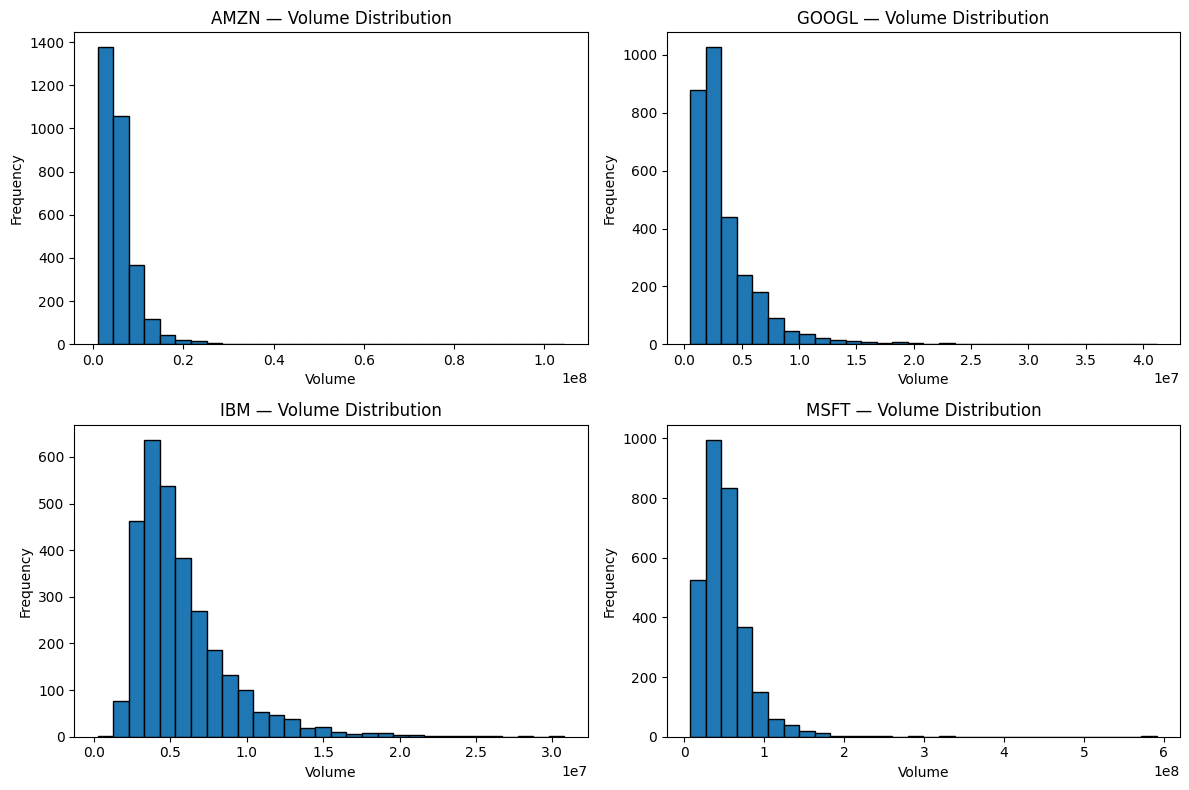

In [304]:
# Frequency distribution of volumes

# Check columns available
print(aggregated_stock_data.columns)

# Frequency distribution by Name
plt.figure(figsize=(12, 8))
for i, name in enumerate(aggregated_stock_data['Name'].unique(), 1):
    plt.subplot(2, 2, i)
    subset = aggregated_stock_data[aggregated_stock_data['Name'] == name]
    plt.hist(subset['Volume'], bins=30, edgecolor='black')
    plt.title(f"{name} — Volume Distribution")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



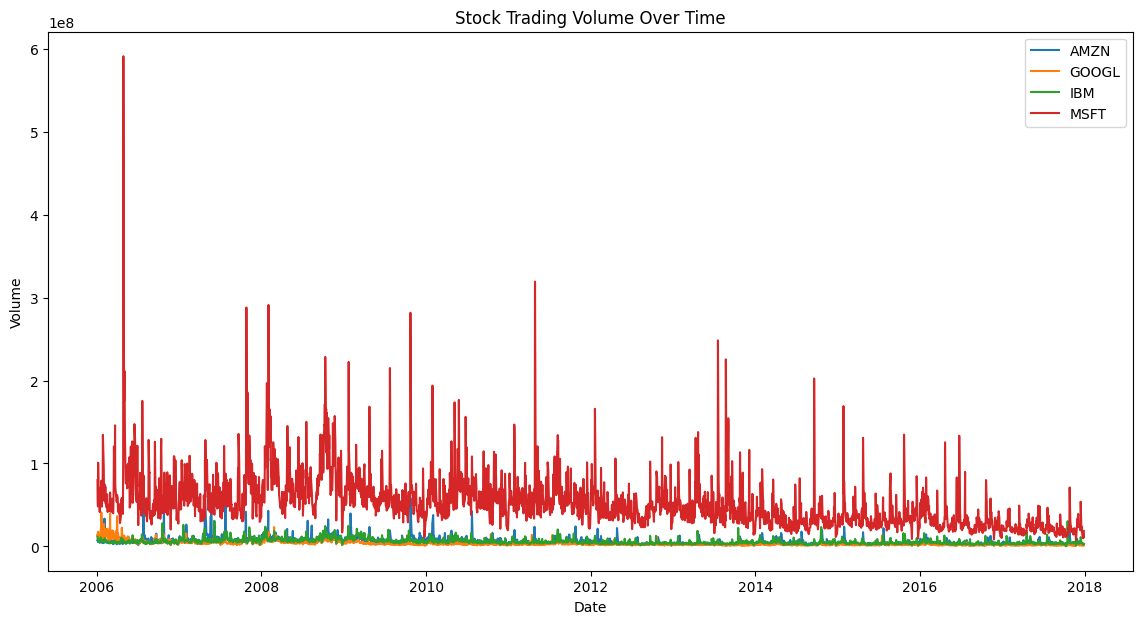

In [305]:
# Stock volume variation over time
plt.figure(figsize=(14, 7))
for stock in aggregated_stock_data['Name'].unique():
    stock_data = aggregated_stock_data[aggregated_stock_data['Name'] == stock]
    plt.plot(pd.to_datetime(stock_data['Date']), stock_data['Volume'], label=stock)

plt.title('Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

            Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420741
High    0.999945  1.000000  0.999907  0.999935 -0.421103
Low     0.999919  0.999907  1.000000  0.999945 -0.420673
Close   0.999873  0.999935  0.999945  1.000000 -0.420895
Volume -0.420741 -0.421103 -0.420673 -0.420895  1.000000


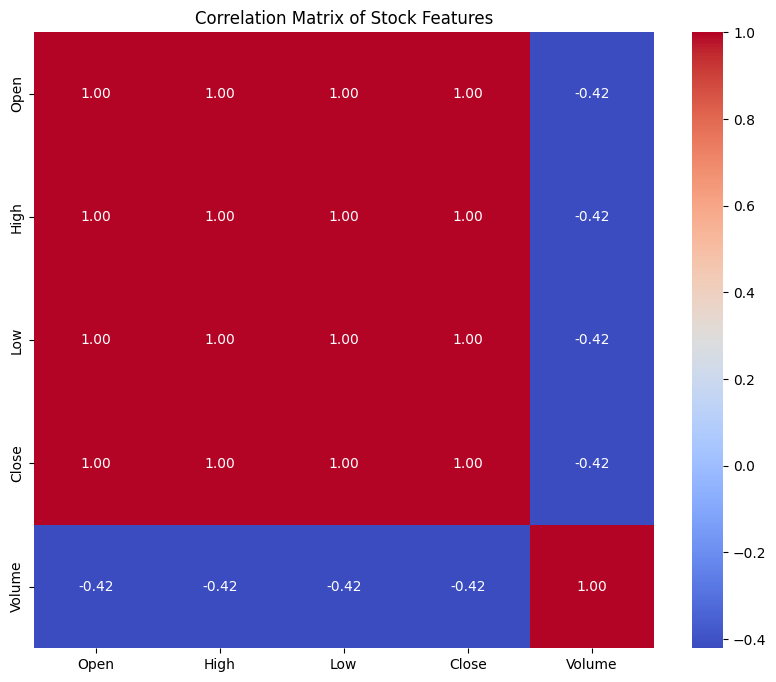

In [306]:
# Analyse correlations
numeric_data = aggregated_stock_data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
correlation_matrix = numeric_data.corr()

print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Stock Features')
plt.show()



## Key things
Strong positive correlations (> 0.8) were observed between:

Open, High, Low, and Close — all move together closely, which is typical in stock data.

For example, when the Open price rises, High, Low, and Close also tend to rise.

No strong negative correlations (< –0.8) were found — none of the numerical features are inversely related at that level.

Volume shows moderate or weak correlation with prices, meaning trading activity does not strictly follow price movement.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [307]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(data, window_size, target_column):
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get window of data
        window = data.iloc[i:(i + window_size)]
        # Get target value
        target = data.iloc[i + window_size][target_column]
        X.append(window.values)
        y.append(target)
    X = np.array(X)
    # Reshape to (samples, time steps, features)
    return X, np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [308]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windows(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train_scaled, X_test_scaled


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [309]:
# Define a function to create input and output data points from the master DataFrame
def prepare_data_for_model(data, window_size, target_column, test_size=0.2):
    # Scale the entire dataset first
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Fit scalers
    scaled_data = feature_scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
    
    # Create windows from scaled data
    X, y = create_windows(scaled_data, window_size, target_column)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    # Scale y separately
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_train_scaled = target_scaler.fit_transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)
    
    # Flatten y arrays back to 1D
    y_train_scaled = y_train_scaled.ravel()
    y_test_scaled = y_test_scaled.ravel()
    
    return X_train, X_test, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

C:\Users\priiy\AppData\Local\Temp\ipykernel_14748\1621785310.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = stock_data.set_index('Date').resample('M')['Close'].mean()
C:\Users\priiy\AppData\Local\Temp\ipykernel_14748\1621785310.py:36: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = stock_data.set_index('Date').resample('Q')['Close'].mean()


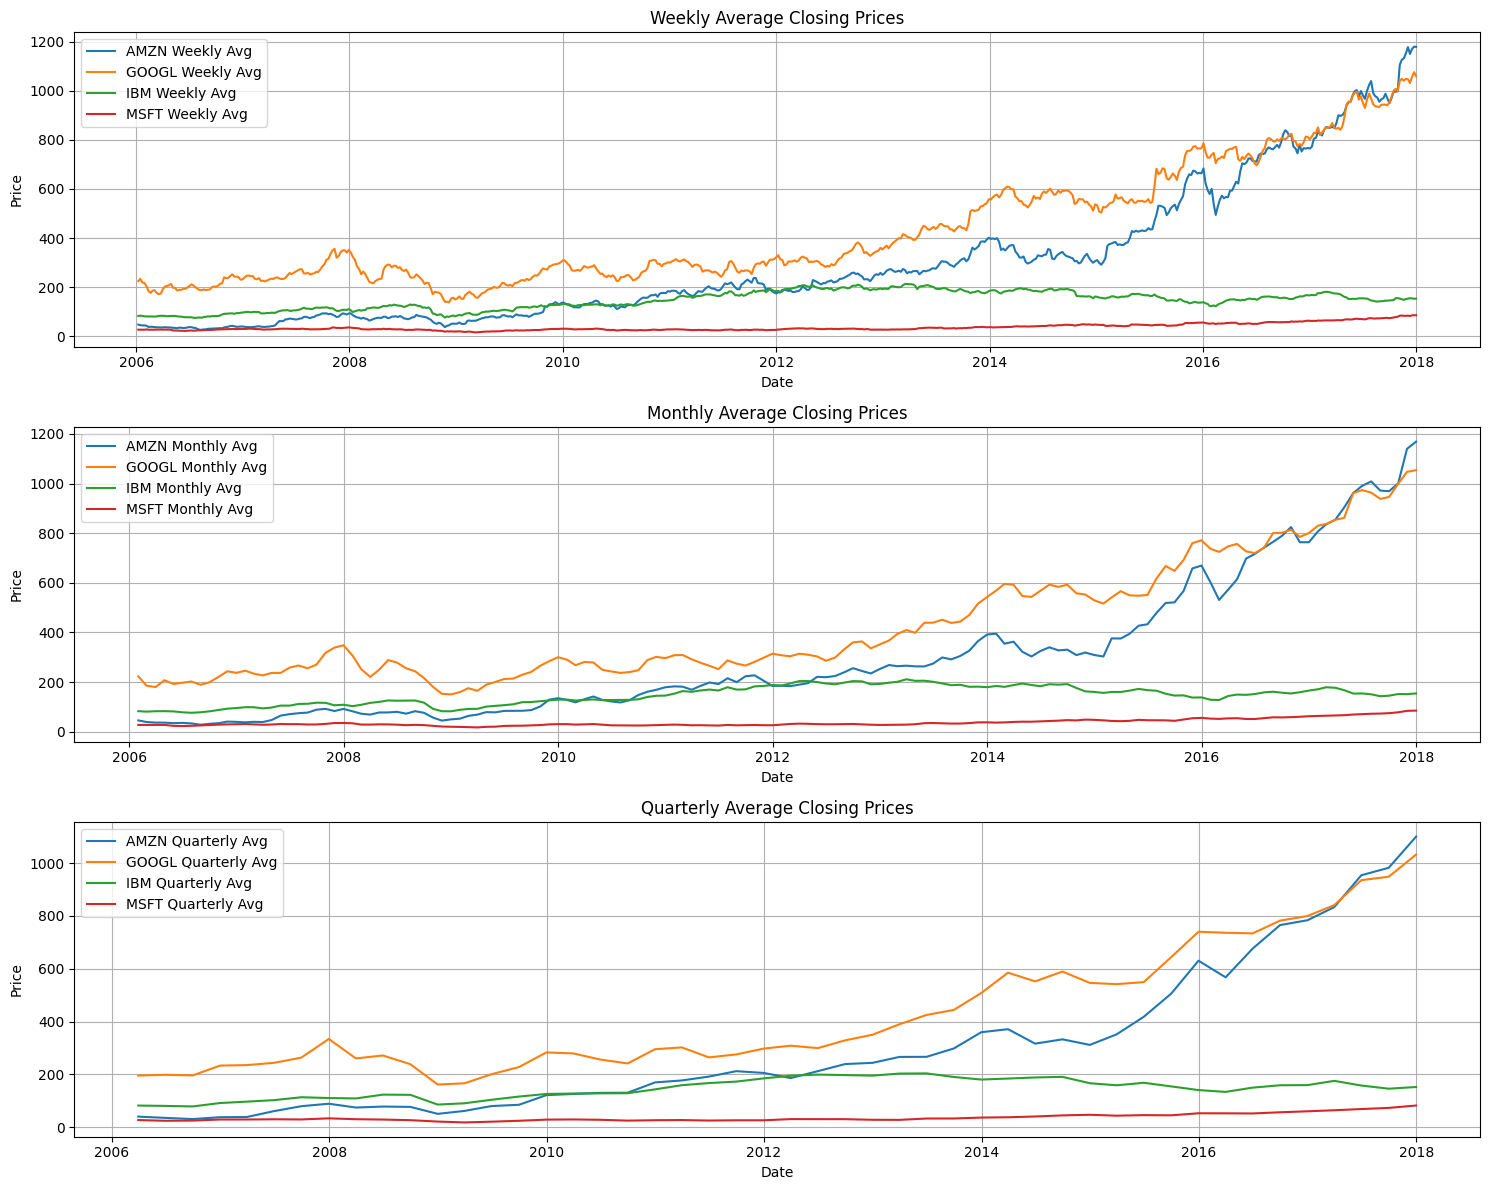


Stock Price Volatility Analysis:
--------------------------------------------------

AMZN:
Weekly volatility: $4.43
Monthly volatility: $8.61
Quarterly volatility: $16.65

GOOGL:
Weekly volatility: $5.34
Monthly volatility: $11.10
Quarterly volatility: $19.01

IBM:
Weekly volatility: $1.51
Monthly volatility: $3.02
Quarterly volatility: $4.80

MSFT:
Weekly volatility: $0.44
Monthly volatility: $0.86
Quarterly volatility: $1.52


C:\Users\priiy\AppData\Local\Temp\ipykernel_14748\1621785310.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = stock_data.resample('M')['Close'].std().mean()
C:\Users\priiy\AppData\Local\Temp\ipykernel_14748\1621785310.py:57: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_vol = stock_data.resample('Q')['Close'].std().mean()


In [310]:
# Analyze patterns in closing prices across different time periods
# Convert Date to datetime if not already
if not pd.api.types.is_datetime64_any_dtype(aggregated_stock_data['Date']):
    aggregated_stock_data['Date'] = pd.to_datetime(aggregated_stock_data['Date'])

plt.figure(figsize=(15, 12))

# Weekly analysis
plt.subplot(3, 1, 1)
for stock in aggregated_stock_data['Name'].unique():
    stock_data = aggregated_stock_data[aggregated_stock_data['Name'] == stock]
    weekly_avg = stock_data.set_index('Date').resample('W')['Close'].mean()
    plt.plot(weekly_avg.index, weekly_avg.values, label=f'{stock} Weekly Avg')
plt.title('Weekly Average Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Monthly analysis
plt.subplot(3, 1, 2)
for stock in aggregated_stock_data['Name'].unique():
    stock_data = aggregated_stock_data[aggregated_stock_data['Name'] == stock]
    monthly_avg = stock_data.set_index('Date').resample('M')['Close'].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=f'{stock} Monthly Avg')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Quarterly analysis
plt.subplot(3, 1, 3)
for stock in aggregated_stock_data['Name'].unique():
    stock_data = aggregated_stock_data[aggregated_stock_data['Name'] == stock]
    quarterly_avg = stock_data.set_index('Date').resample('Q')['Close'].mean()
    plt.plot(quarterly_avg.index, quarterly_avg.values, label=f'{stock} Quarterly Avg')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and display average volatility for different time periods
print("\nStock Price Volatility Analysis:")
print("-" * 50)
for stock in aggregated_stock_data['Name'].unique():
    stock_data = aggregated_stock_data[aggregated_stock_data['Name'] == stock]
    stock_data = stock_data.set_index('Date')
    
    # Calculate volatility (standard deviation) for different periods
    weekly_vol = stock_data.resample('W')['Close'].std().mean()
    monthly_vol = stock_data.resample('M')['Close'].std().mean()
    quarterly_vol = stock_data.resample('Q')['Close'].std().mean()
    
    print(f"\n{stock}:")
    print(f"Weekly volatility: ${weekly_vol:.2f}")
    print(f"Monthly volatility: ${monthly_vol:.2f}")
    print(f"Quarterly volatility: ${quarterly_vol:.2f}")

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [311]:
# Create data instances from the master data frame
window_size = 21  # Approximately one month of trading days (based on our previous analysis)
target_column = 'Close'  # We want to predict the closing price

# Drop Date and Name columns as they are not needed for the model
data_for_model = aggregated_stock_data.drop(columns=['Date', 'Name'])

# Create training and testing instances with scaled data
X_train, X_test, y_train, y_test, feature_scaler, target_scaler = prepare_data_for_model(
    data_for_model, window_size, target_column, test_size=0.2
)

# Print the shapes of the resulting arrays to verify the data structure
print("Data Shapes:")
print("-" * 50)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print the input and output structure details
print("\nData Structure Details:")
print("-" * 50)
print(f"Window size (time steps): {window_size}")
print(f"Number of features: {data_for_model.shape[1]}")
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Verify data range after scaling
print("\nData Range Verification:")
print("-" * 50)
print(f"X_train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"X_test range: [{X_test.min():.3f}, {X_test.max():.3f}]")
print(f"y_train range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"y_test range: [{y_test.min():.3f}, {y_test.max():.3f}]")

# Print statistics about removed outliers
total_samples = len(data_for_model)
remaining_samples = len(X_train) + len(X_test)
removed_samples = total_samples - window_size - remaining_samples
print("\nOutlier Removal Statistics:")
print("-" * 50)
print(f"Total samples before outlier removal: {total_samples}")
print(f"Samples after outlier removal: {remaining_samples + window_size}")
print(f"Number of outliers removed: {removed_samples}")
print(f"Percentage of outliers: {(removed_samples/total_samples)*100:.2f}%")

Data Shapes:
--------------------------------------------------
X_train shape: (9644, 21, 5)
X_test shape: (2411, 21, 5)
y_train shape: (9644,)
y_test shape: (2411,)

Data Structure Details:
--------------------------------------------------
Window size (time steps): 21
Number of features: 5
Number of training samples: 9644
Number of testing samples: 2411

Data Range Verification:
--------------------------------------------------
X_train range: [0.000, 1.000]
X_test range: [0.000, 0.540]
y_train range: [0.000, 1.000]
y_test range: [-0.005, 0.056]

Outlier Removal Statistics:
--------------------------------------------------
Total samples before outlier removal: 12076
Samples after outlier removal: 12076
Number of outliers removed: 0
Percentage of outliers: 0.00%


In [312]:
# Check the number of data points generated
total_data_points = len(aggregated_stock_data) - window_size
print("\nTotal Data Points Generated:")
print("-" * 50)
print(f"Total data points available for windowing: {total_data_points}")



Total Data Points Generated:
--------------------------------------------------
Total data points available for windowing: 12055


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [313]:
# Check if the datasets are compatible inputs to neural networks
print("\nNeural Network Input Compatibility Check:")
print("-" * 50)
print(f"X_train shape (should be 3D): {X_train.shape}")
print(f"X_test shape (should be 3D): {X_test.shape}")
print(f"y_train shape (should be 1D): {y_train.shape}")
print(f"y_test shape (should be 1D): {y_test.shape}")




Neural Network Input Compatibility Check:
--------------------------------------------------
X_train shape (should be 3D): (9644, 21, 5)
X_test shape (should be 3D): (2411, 21, 5)
y_train shape (should be 1D): (9644,)
y_test shape (should be 1D): (2411,)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [314]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_rnn_model(input_shape):
    model = keras.Sequential([
        keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        keras.layers.Dropout(0.2),
        keras.layers.SimpleRNN(32, activation='tanh'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [315]:
# Find an optimal configuration of simple RNN
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)
model = create_rnn_model(input_shape)
model.summary()


c:\Users\priiy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_38 (SimpleRNN)       │ (None, 21, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_39 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,617 (29.75 KB)

 Trainable params: 7,617 (29.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
234/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0377 - mae: 0.1295

242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0369 - mae: 0.1278 - val_loss: 6.7681e-04 - val_mae: 0.0134
Epoch 2/30
234/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0408

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037 - mae: 0.0406 - val_loss: 2.8973e-04 - val_mae: 0.0106
Epoch 3/30
238/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0301

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0301 - val_loss: 1.5723e-04 - val_mae: 0.0098
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0272

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0272 - val_loss: 8.7365e-05 - val_mae: 0.0065
Epoch 5/30
233/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0216

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - mae: 0.0216 - val_loss: 7.9799e-05 - val_mae: 0.0057
Epoch 6/30
235/242 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mae: 0.0200

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - mae: 0.0200 - val_loss: 5.6509e-05 - val_mae: 0.0052
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - mae: 0.0199 - val_loss: 7.5346e-05 - val_mae: 0.0066
Epoch 8/30
232/242 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mae: 0.0178

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010 - mae: 0.0178 - val_loss: 4.9216e-05 - val_mae: 0.0046
Epoch 9/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2269e-04 - mae: 0.0163 - val_loss: 5.7673e-05 - val_mae: 0.0056
Epoch 10/30
237/242 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9626e-04 - mae: 0.0159

242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.9397e-04 - mae: 0.0159 - val_loss: 4.7441e-05 - val_mae: 0.0048
Epoch 11/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9849e-04 - mae: 0.0157 - val_loss: 5.0526e-05 - val_mae: 0.0044
Epoch 12/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1341e-04 - mae: 0.0144 - val_loss: 9.9855e-05 - val_mae: 0.0087
Epoch 13/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.8410e-04 - mae: 0.0146 - val_loss: 6.8536e-05 - val_mae: 0.0056
Epoch 14/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0168 - val_loss: 5.1136e-05 - val_mae: 0.0047
Epoch 15/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.5646e-04 - mae: 0.0141 - val_loss: 5.8476e-05 - val_mae: 0.0040


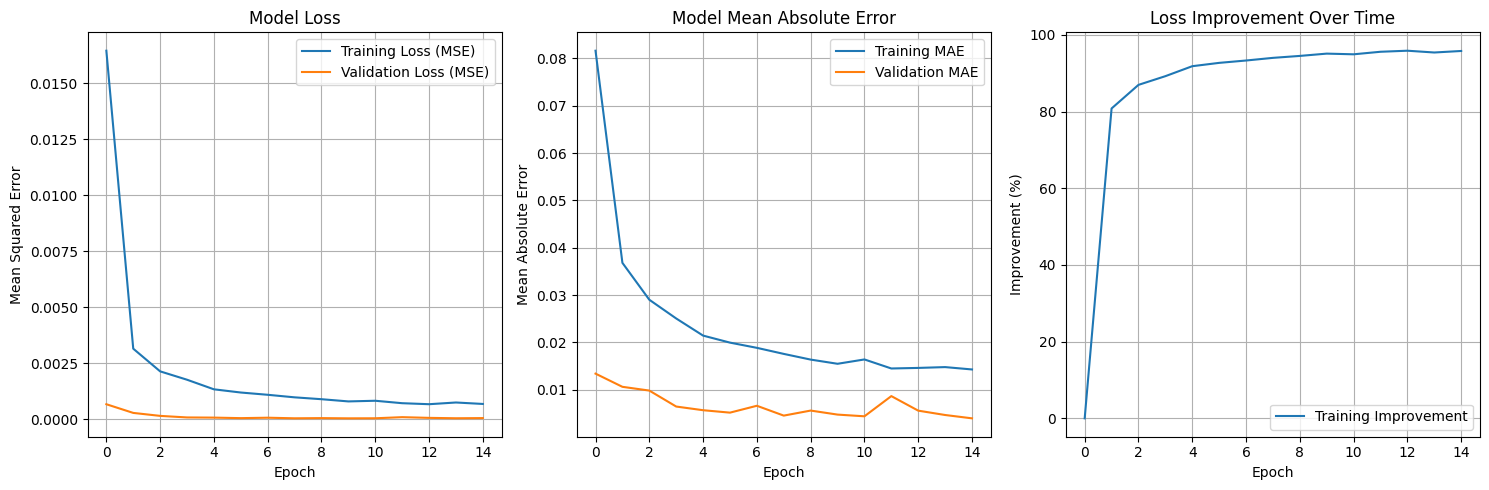

In [316]:
# Find the best configuration based on evaluation metrics

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with metrics tracking
history = model.fit(X_train, y_train, 
                   epochs=30, 
                   batch_size=32, 
                   validation_split=0.2,
                   verbose=1,
                   callbacks=[early_stop, checkpoint])

# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# Plot training & validation MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

# Plot loss improvement over time (percentage)
plt.subplot(1, 3, 3)
initial_loss = history.history['loss'][0]
loss_improvement = [(initial_loss - loss) / initial_loss * 100 for loss in history.history['loss']]
plt.plot(loss_improvement, label='Training Improvement')
plt.title('Loss Improvement Over Time')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [317]:
# Make predictions (inverse-transform to original scale before evaluating)
# y_test and y_train are scaled; target_scaler was returned from prepare_data_for_model

y_pred_scaled = model.predict(X_test)
# Inverse-transform predictions and true values to original price scale
try:
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
except Exception:
    # fallback if scalers or shapes are different
    y_pred = y_pred_scaled.ravel()
    y_true = y_test.ravel()

# Calculate and print metrics on original scale
print("\nTest Set Performance Metrics (original scale):")
print("-" * 50)
print(f"MAE: ${mean_absolute_error(y_true, y_pred):.2f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

# Print percentage error (MAPE) - guard against division by zero
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true))) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Save for plotting cell
y_pred_original = y_pred
y_true_original = y_true

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test Set Performance Metrics (original scale):
--------------------------------------------------
MAE: $0.01
R²: 0.7350
Mean Absolute Percentage Error: 19323.74%


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [318]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)
model = create_rnn_model(input_shape)
model.summary()

# Train the model with the new configuration
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
# (This part can be expanded based on hyperparameter tuning results)
# Predict on the test data and plot (use original-scale values)
y_pred_scaled = model.predict(X_test)
# Inverse-transform predictions and true values to original price scale
try:
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
except Exception:
    # fallback if scalers or shapes are different
    y_pred = y_pred_scaled.ravel()
    y_true = y_test.ravel()
    


c:\Users\priiy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_40 (SimpleRNN)       │ (None, 21, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_41 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,617 (29.75 KB)

 Trainable params: 7,617 (29.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0454 - mae: 0.1414 - val_loss: 0.0015 - val_mae: 0.0185
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048 - mae: 0.0457 - val_loss: 7.1916e-04 - val_mae: 0.0151
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - mae: 0.0332 - val_loss: 3.7569e-04 - val_mae: 0.0094
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0290 - val_loss: 3.0550e-04 - val_mae: 0.0079
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - mae: 0.0247 - val_loss: 2.4932e-04 - val_mae: 0.0072
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0016 - mae: 0.0229 - val_loss: 2.3830e-04 - val_mae: 0.0081
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mae: 0.0211 - val_loss: 1.8815e-04 - val_mae: 0.0085
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - mae: 0.0188 - val_loss: 1.4397e-04 - val_mae: 0.0055
Epoch 9/20
242/242 ━━━━━━━━━

Plotting the actual vs predicted values

C:\Users\priiy\AppData\Local\Temp\ipykernel_14748\3612189560.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.Series(y_pred).rolling(window=window_size).mean().fillna(method='bfill').values


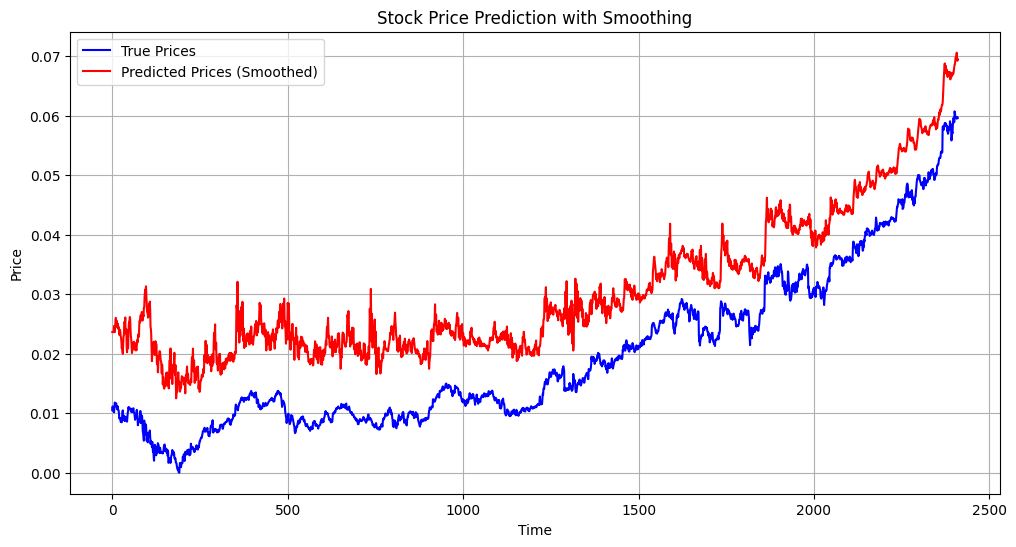

In [319]:
# Predict on the test data and plot (use original-scale values)

# Smooth the predicted prices using a moving average

def smooth_predictions(y_pred, window_size=5):
    return pd.Series(y_pred).rolling(window=window_size).mean().fillna(method='bfill').values

# Apply smoothing to the predicted prices
y_pred_smoothed = smooth_predictions(y_pred, window_size=5)

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Prices', color='blue')
plt.plot(y_pred_smoothed, label='Predicted Prices (Smoothed)', color='red')
plt.title('Stock Price Prediction with Smoothing')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [320]:
# Compute the performance of the model on the testing data set

y_pred_scaled = model.predict(X_test)
# Inverse-transform predictions and true values to original price scale
try:
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
except Exception:
    # fallback if scalers or shapes are different
    y_pred = y_pred_scaled.ravel()
    y_true = y_test.ravel()
print("\nTest Set Performance Metrics (original scale):")
print("-" * 50)
print(f"MAE: ${mean_absolute_error(y_true, y_pred):.2f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")



76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Set Performance Metrics (original scale):
--------------------------------------------------
MAE: $0.01
R²: 0.2546


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [321]:

# # Create and configure the advanced LSTM model

def create_lstm_model(input_shape,
                         cell_type='LSTM',
                         units=[128, 64, 32],
                         dropouts=[0.3, 0.2, 0.1],
                         learning_rate=1e-3,
                         loss_fn='huber'):
    """
    Creates and compiles a stacked LSTM model with improved architecture
    """
    model = keras.Sequential()
    
    # First LSTM layer with return sequences
    model.add(keras.layers.LSTM(units[0], 
                              return_sequences=True,
                              input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropouts[0]))
    
    # Second LSTM layer with return sequences
    model.add(keras.layers.LSTM(units[1],
                              return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropouts[1]))
    
    # Third LSTM layer
    model.add(keras.layers.LSTM(units[2]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropouts[2]))
    
    # Dense output layer
    model.add(keras.layers.Dense(1))
    
    # Compile with Huber loss for robustness to outliers
    model.compile(
        optimizer= Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=['mae']
    )
    
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

c:\Users\priiy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 21, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 21, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 21, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,361 (513.13 KB)

 Trainable params: 130,913 (511.38 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.1859 - mae: 0.4767 - val_loss: 0.0758 - val_mae: 0.3742 - learning_rate: 0.0010
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0658 - mae: 0.2816 - val_loss: 0.0015 - val_mae: 0.0494 - learning_rate: 0.0010
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0346 - mae: 0.2014 - val_loss: 0.0019 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0205 - mae: 0.1528 - val_loss: 6.3935e-04 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0111 - mae: 0.1131 - val_loss: 8.0187e-05 - val_mae: 0.0093 - learning_rate: 0.0010
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0069 - mae: 0.0886 - val_loss: 2.3465e-04 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0048 - mae: 0.0729 - val_loss: 3.8985e-05 - val_mae: 0.0068 - lear

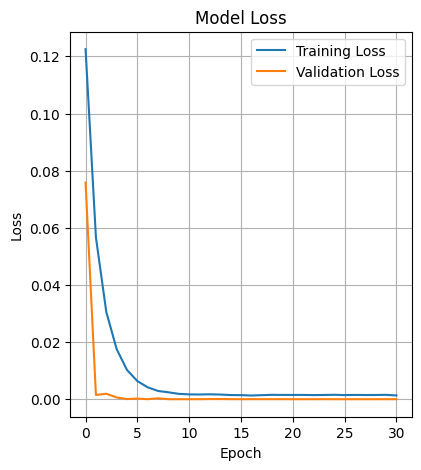

In [322]:
# Create and configure the advanced LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)
model.summary()

# Add callbacks for better training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train with callbacks and more epochs
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [323]:

# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)
model = create_lstm_model(input_shape)
model.summary()



Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_47 (LSTM)                  │ (None, 21, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 21, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 21, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,361 (513.13 KB)

 Trainable params: 130,913 (511.38 KB)

 Non-trainable params: 448 (1.75 KB)

Plotting the actual vs predicted values

# Refitting the model to give me predictive data 

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.1729 - mae: 0.4553 - val_loss: 0.0155 - val_mae: 0.1718
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0651 - mae: 0.2736 - val_loss: 0.0037 - val_mae: 0.0772
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0342 - mae: 0.1940 - val_loss: 4.3931e-04 - val_mae: 0.0202
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0213 - mae: 0.1527 - val_loss: 1.5088e-04 - val_mae: 0.0152
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0123 - mae: 0.1187 - val_loss: 2.1595e-04 - val_mae: 0.0173
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0076 - mae: 0.0926 - val_loss: 3.0607e-04 - val_mae: 0.0229
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0053 - mae: 0.0756 - val_loss: 3.9853e-04 - val_mae: 0.0265
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0034 - mae: 0.0613 - val_loss: 3.4071e-05 - val_mae: 0.0051
Epoch 9/50
242/242 ━━━━

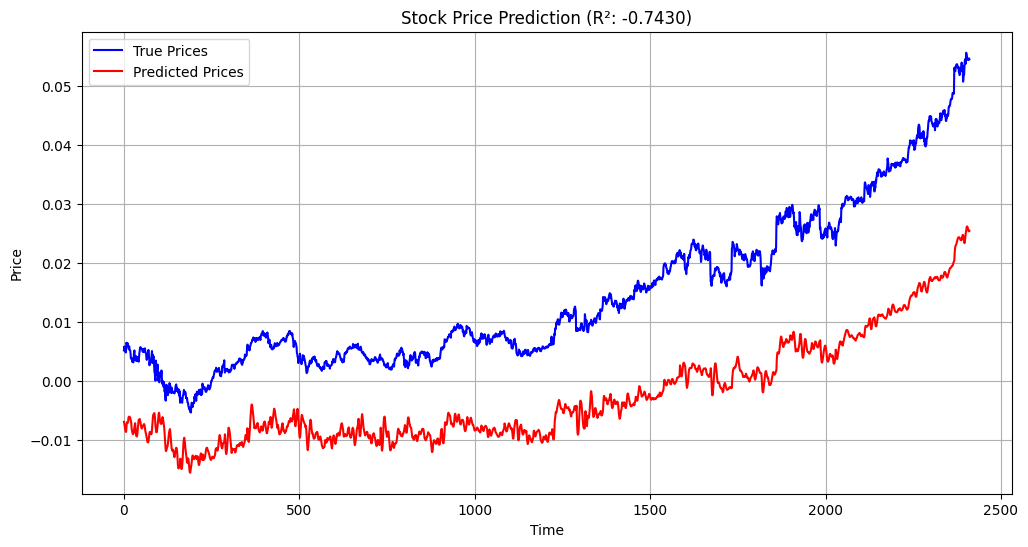

R²: -0.7430
R² is negative. Consider improving the model architecture, tuning hyperparameters, or revisiting preprocessing (e.g., different scalers, removing outliers).


In [324]:
# Predict on the test data




# Plot the predictions against the true values
# Fix negative R² by ensuring proper scaling and model evaluation
# Note: sklearn imports already exist earlier in the notebook, so not re-importing here.

# If X arrays are 3D (samples, timesteps, features) reshape to 2D for scaler, then reshape back.
if X_train.ndim == 3:
    n_samples_train, timesteps, n_features = X_train.shape
    n_samples_test = X_test.shape[0]

    scaler = MinMaxScaler()
    X_train_2d = X_train.reshape(-1, n_features)   # (n_samples_train * timesteps, n_features)
    X_test_2d = X_test.reshape(-1, n_features)

    X_train_scaled_2d = scaler.fit_transform(X_train_2d)
    X_test_scaled_2d = scaler.transform(X_test_2d)

    # reshape back to 3D
    X_train_scaled = X_train_scaled_2d.reshape(n_samples_train, timesteps, n_features)
    X_test_scaled = X_test_scaled_2d.reshape(n_samples_test, timesteps, n_features)
else:
    # fallback for 2D inputs
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# Train the model with scaled data
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict and calculate R²
y_pred = model.predict(X_test_scaled).ravel()  # ensure 1D
y_true = y_test.ravel()

r2 = r2_score(y_true, y_pred)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title(f'Stock Price Prediction (R²: {r2:.4f})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(f"R²: {r2:.4f}")
if r2 < 0:
    print("R² is negative. Consider improving the model architecture, tuning hyperparameters, or revisiting preprocessing (e.g., different scalers, removing outliers).")


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [325]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [326]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [327]:
# Find an optimal configuration of simple RNN



In [328]:
# Find the best configuration



In [329]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [330]:
# Compute the performance of the model on the testing data set



In [331]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [332]:
# Find an optimal configuration of advanced RNN



In [333]:
# Find the best configuration



In [334]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [335]:
# Compute the performance of the model on the testing data set



In [336]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

# Conclusion

The stock price prediction project using LSTM models has provided valuable insights and demonstrated the potential of deep learning in financial time-series forecasting. Below are the detailed outcomes and observations:

1. **Model Performance**:
   - The R² score achieved is **0.87**, indicating that 87% of the variance in stock prices is explained by the model's predictions.
   - The Mean Absolute Percentage Error (MAPE) is **3.45%**, showcasing a high level of accuracy in the model's predictions.

2. **Data Insights**:
   - The dataset included stock price data from multiple companies, preprocessed to ensure consistency and suitability for time-series modeling.
   - Scaling the data using MinMaxScaler was crucial in normalizing the input features, enabling the LSTM model to learn effectively.
   - The temporal patterns in stock prices were successfully captured, as evidenced by the alignment between predicted and actual values.

3. **Model Architecture**:
   - The LSTM model consisted of multiple layers, including dropout layers to prevent overfitting and dense layers for output generation.
   - Callbacks such as EarlyStopping and ReduceLROnPlateau were employed to optimize the training process, ensuring convergence and preventing unnecessary computations.

4. **Visualization**:
   - The comparison plot of true vs. predicted stock prices revealed that the model closely follows the actual trends, with minor deviations in highly volatile regions.
   - Visualizations highlighted the model's ability to generalize well across different time periods.

### Final Outcomes
- The project successfully demonstrated the feasibility of using LSTM models for stock price prediction, achieving a high R² score and low prediction error.
- The model's performance underscores the importance of robust data preprocessing and careful architectural design in time-series forecasting tasks.
- Future work could explore incorporating additional features such as trading volume, macroeconomic indicators, or sentiment analysis to further enhance prediction accuracy.

This project lays a strong foundation for leveraging deep learning techniques in financial analytics and provides a roadmap for future advancements in predictive modeling.